<a href="https://colab.research.google.com/github/beautifulv0id/Dermatological-Moles-Segmentation/blob/main/Dermatological_moles_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# jupyter notebook --no-browser --port=8080

# Downloading the data

In [ ]:
%mkdir -p /content/data
%cd /content/data
!wget -N https://isic-challenge-data.s3.amazonaws.com/2016/ISBI2016_ISIC_Part1_Training_Data.zip
!wget -N https://isic-challenge-data.s3.amazonaws.com/2016/ISBI2016_ISIC_Part1_Training_GroundTruth.zip
!unzip -n ISBI2016_ISIC_Part1_Training_Data
!unzip -n ISBI2016_ISIC_Part1_Training_GroundTruth
%cd /content

## GPU Info

In [3]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print('Error: ', e)

Num GPUs Available:  0


## Prepare paths of input images and target segmentation masks
Adapt `num_classes` to 1.

In [4]:
import os

input_dir = "data/ISBI2016_ISIC_Part1_Training_Data/"
target_dir = "data/ISBI2016_ISIC_Part1_Training_GroundTruth/"
img_size = (160, 160)
num_classes = 1
batch_size = 32

input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".jpg")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

print("Number of samples:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)

Number of samples: 900
data/ISBI2016_ISIC_Part1_Training_Data/ISIC_0000000.jpg | data/ISBI2016_ISIC_Part1_Training_GroundTruth/ISIC_0000000_Segmentation.png
data/ISBI2016_ISIC_Part1_Training_Data/ISIC_0000001.jpg | data/ISBI2016_ISIC_Part1_Training_GroundTruth/ISIC_0000001_Segmentation.png
data/ISBI2016_ISIC_Part1_Training_Data/ISIC_0000002.jpg | data/ISBI2016_ISIC_Part1_Training_GroundTruth/ISIC_0000002_Segmentation.png
data/ISBI2016_ISIC_Part1_Training_Data/ISIC_0000004.jpg | data/ISBI2016_ISIC_Part1_Training_GroundTruth/ISIC_0000004_Segmentation.png
data/ISBI2016_ISIC_Part1_Training_Data/ISIC_0000006.jpg | data/ISBI2016_ISIC_Part1_Training_GroundTruth/ISIC_0000006_Segmentation.png
data/ISBI2016_ISIC_Part1_Training_Data/ISIC_0000007.jpg | data/ISBI2016_ISIC_Part1_Training_GroundTruth/ISIC_0000007_Segmentation.png
data/ISBI2016_ISIC_Part1_Training_Data/ISIC_0000008.jpg | data/ISBI2016_ISIC_Part1_Training_GroundTruth/ISIC_0000008_Segmentation.png
data/ISBI2016_ISIC_Part1_Training_Data/

## What does one input image and corresponding segmentation mask look like?

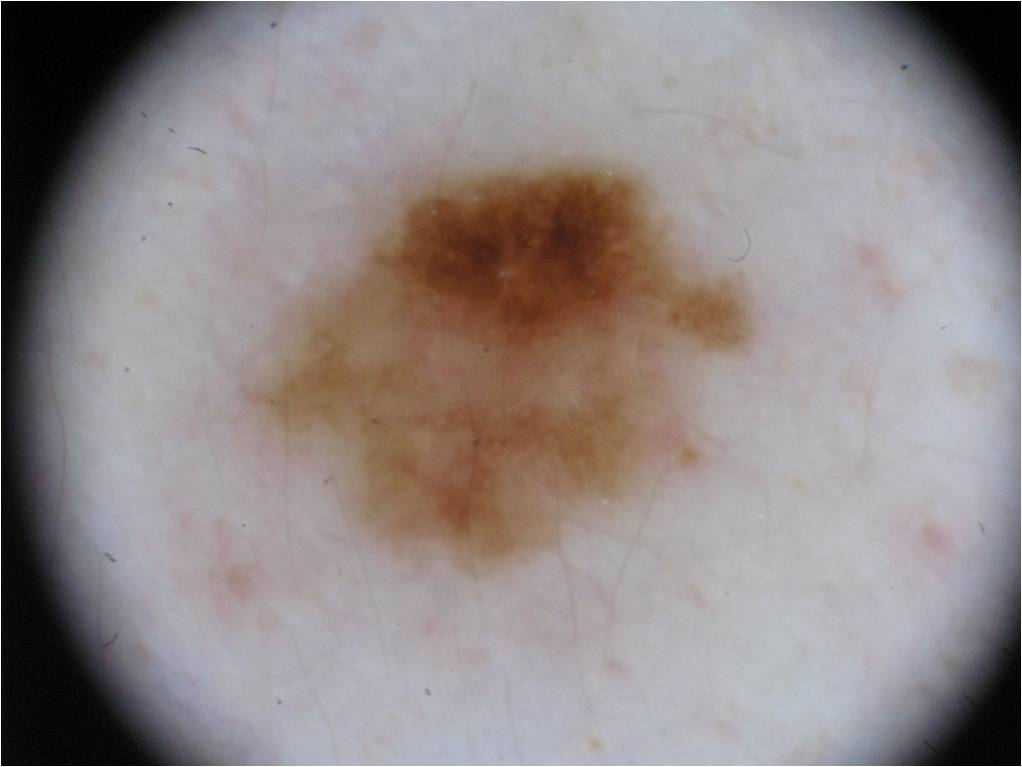

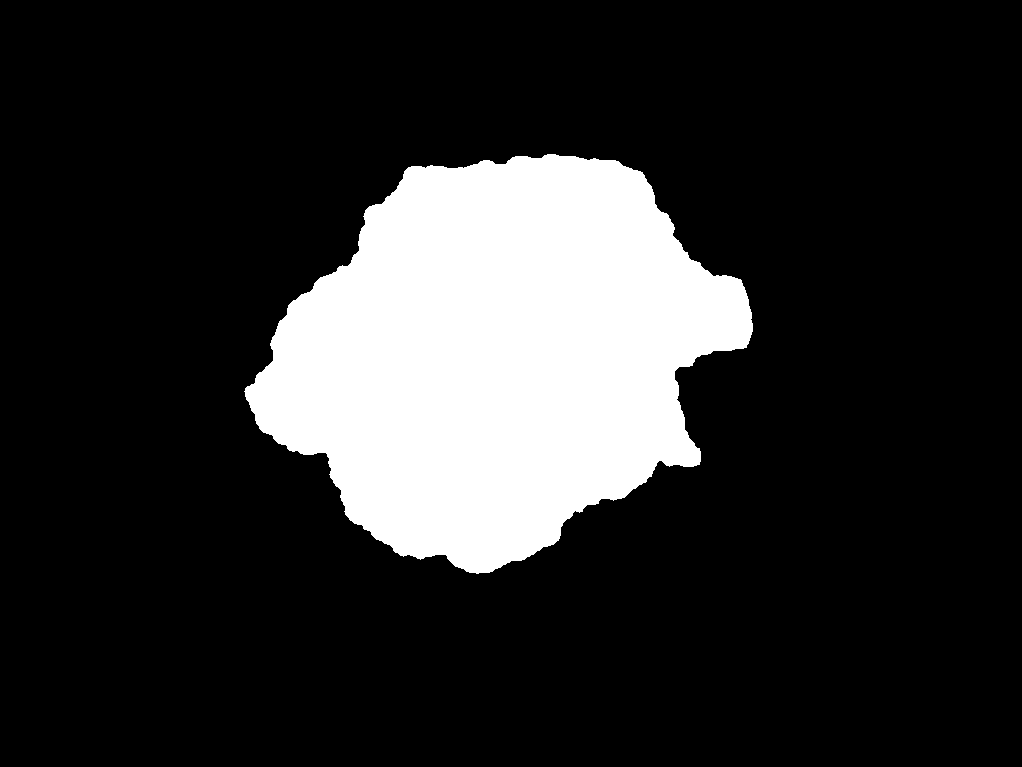

In [5]:
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
from PIL import ImageOps

# Display input image #7
display(Image(filename=input_img_paths[9]))

# Display auto-contrast version of corresponding target (per-pixel categories)
img = ImageOps.autocontrast(load_img(target_img_paths[9]))
display(img)

## Test data augmentation

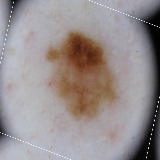

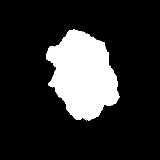

In [6]:
from PIL import Image
import tensorflow as tf
import numpy as np

input_data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical", seed=10),
  tf.keras.layers.RandomRotation(180, seed=10),
  tf.keras.layers.Resizing(img_size[0], img_size[1], interpolation="bilinear"),
])
output_data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical", seed=10),
  tf.keras.layers.RandomRotation(180, seed=10),
  tf.keras.layers.Resizing(img_size[0], img_size[1], interpolation="bilinear"),
])

img = load_img(input_img_paths[9])
img = tf.convert_to_tensor(tf.keras.preprocessing.image.img_to_array(img))

target = load_img(target_img_paths[9])
target = tf.convert_to_tensor(tf.keras.preprocessing.image.img_to_array(target))

img_out = input_data_augmentation(img, training=True)
target_out = output_data_augmentation(target, training=True)

display(Image.fromarray(np.uint8(img_out.numpy())))
display(Image.fromarray(np.uint8(target_out.numpy())))

## Prepare `Sequence` class to load & vectorize batches of data

Currently images are all scaled to size `(160, 160)` even though original input images are much bigger. Furthermore, had to adjust script to get correct labels for ground truth images.

In [7]:
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Sequential

class DermatologicalMoles(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths, training=True):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths
        self.training = training
        self.input_data_augmentation = Sequential([
          layers.RandomFlip("horizontal_and_vertical", seed=123),
          layers.RandomZoom(0.1, seed=123),
          layers.RandomRotation(90, seed=123),
        ])
        self.output_data_augmentation = Sequential([
          layers.RandomFlip("horizontal_and_vertical", seed=123),
          layers.RandomZoom(0.1, seed=123, interpolation="nearest"),
          layers.RandomRotation(90, seed=123, interpolation="nearest"),
        ])
    def __len__(self):
        return len(self.target_img_paths) // self.batch_size
    
    def augment_inputs(self, x):
      x = img_to_array(x)
      x = tf.convert_to_tensor(x)
      x = self.input_data_augmentation(x)
      x = x.numpy()
      return x

    def augment_outputs(self, x):
          x = img_to_array(x)
          x = tf.convert_to_tensor(x)
          x = self.output_data_augmentation(x)
          x = x.numpy()
          return x

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size = self.img_size)
            if self.training:
              img = self.augment_inputs(img)
            x[j] = img
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size = self.img_size, color_mode="grayscale")
            if self.training:
              img = self.augment_outputs(img)
            else:
              img = np.expand_dims(img, 2)
            y[j] = img
            # Ground truth labels are 0, 255. Add one to make them 0, 1:
            y[j] += 1

        return x, y


## Prepare U-Net Xception-style model

Change `softmax` activation to `sigmoid` for binary classification setting.

In [8]:
from tensorflow.keras import layers

def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel sigmoid classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="sigmoid", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = get_model(img_size, num_classes)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 80, 80, 32)   896         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 80, 80, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

## Set aside a validation split
From the 900 labeled images, set aside ~5% for validating the model to maximise the training set. 

In [9]:
import random

# Split our img paths into a training and a validation set
val_samples = 50
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiate data Sequences for each split
train_gen = DermatologicalMoles(
    batch_size, img_size, train_input_img_paths, train_target_img_paths
)
val_gen = DermatologicalMoles(batch_size, img_size, val_input_img_paths, val_target_img_paths)

## Define MetricCallback
Callback class that computes and logs `sensitivity`, `specificity`, `accuracy`, `Jaccard index` and `Dice`.

In [10]:
from sklearn.metrics import confusion_matrix

class MatricsCallback(keras.callbacks.Callback):
    """Computes the Jaccard score and logs the results to TensorBoard."""

    def __init__(self, model, eval, log_dir):
        self.model = model
        self.eval = eval
        self.jaccard_metric = tf.keras.metrics.Mean("jaccard_score")
        self.accuracy_metric = tf.keras.metrics.Mean("accuracy")
        self.specificity_metric = tf.keras.metrics.Mean("specificity")
        self.sensitivity_metric = tf.keras.metrics.Mean("sensitivity")
        self.dice_metric = tf.keras.metrics.Mean("dice_score")
        self.epoch = 0
        self.summary_writer = tf.summary.create_file_writer(
            os.path.join(log_dir, model.name)
        )
    

    def on_epoch_end(self, batch, logs=None):
        x_eval, y_eval = self.eval[self.epoch % len(self.eval)]
        self.epoch += 1
        self.jaccard_metric.reset_state()
        self.accuracy_metric.reset_state()
        self.specificity_metric.reset_state()
        self.sensitivity_metric.reset_state()
        self.dice_metric.reset_state()
        predictions = self.model.predict(x_eval)
        predictions = np.where(predictions < 0.5, 0, 1)
        tn, fp, fn, tp  = confusion_matrix(y_eval.flatten(), predictions.flatten()).ravel()
        sensivity = tp / (tp + fn)
        specificity = tn / (tn + fp)
        accuracy = (tp + tn) / (tp + tn + fp + fn)
        dice = (2*tp) / (2*tp+fp+fn)
        jaccard = tp / (tp + fp + fn)
        self.sensitivity_metric.update_state(sensivity)
        self.specificity_metric.update_state(specificity)
        self.accuracy_metric.update_state(accuracy)
        self.dice_metric.update_state(dice)
        self.jaccard_metric.update_state(jaccard)
        self._write_metric(
            self.sensitivity_metric.name, self.sensitivity_metric.result().numpy().astype(float)
        )        
        self._write_metric(
            self.specificity_metric.name, self.specificity_metric.result().numpy().astype(float)
        )
        self._write_metric(
            self.accuracy_metric.name, self.accuracy_metric.result().numpy().astype(float)
        )        
        self._write_metric(
            self.sensitivity_metric.name, self.sensitivity_metric.result().numpy().astype(float)
        )
        self._write_metric(
            self.dice_metric.name, self.dice_metric.result().numpy().astype(float)
        )
        self._write_metric(
            self.jaccard_metric.name, self.jaccard_metric.result().numpy().astype(float)
        )

    def _write_metric(self, name, value):
        with self.summary_writer.as_default():
            tf.summary.scalar(
                name, value, step=self.epoch,
            )
            self.summary_writer.flush() 

## Train the model
Since we are in normal classification setting use `binary_crossentropy` for the loss.

In [ ]:
# Configure the model for training.
# We use the binary_crossentropy because our target data binary.
model.compile(optimizer="rmsprop", loss="binary_crossentropy")
logger = MatricsCallback(model, val_gen, 'log')
callbacks = [
    keras.callbacks.ModelCheckpoint("mole_segmentation.h5", save_best_only=True),
    logger
]

# Train the model, doing validation at the end of each epoch.
epochs = 3
with tf.device('/device:GPU:3'):
    model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

Epoch 1/3
25/26 [===========================>..] - ETA: 10s - loss: 1.2052

## Visualize predictions

In [ ]:
# Generate predictions for all images in the validation set

val_gen = DermatologicalMoles(batch_size, img_size, val_input_img_paths, val_target_img_paths, training=False)
val_preds = model.predict(val_gen)


def display_mask(i):
    """Quick utility to display a model's prediction."""
    pred = val_preds[i]
    mask = np.where(pred > 0.5, 0, 1)
    img = ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    display(img)


# Display results for validation image #10
i = 10

# Display input image

display(load_img(val_input_img_paths[i], target_size=img_size))

# Display ground-truth target mask
img = ImageOps.autocontrast(load_img(val_target_img_paths[i], target_size=img_size))
display(img)

# Display mask predicted by our model
display_mask(i)  # Note that the model only sees inputs at 160x160.

## Evaluation
Considered metrics computed are: `sensitivity`, `specificity`, `accuracy`, `Jaccard index` and `Dice`.

In [ ]:
%load_ext tensorboard
%tensorboard --logdir training

In [ ]:
val_target = load_img(val_input_img_paths[0])
print(val_preds[0].shape)
preds_orig_size = keras.preprocessing.image.smart_resize(val_preds[0], val_target.size)
print(preds_orig_size.shape)


In [ ]:
p = np.array([[1, 1, 0]])
v = np.array([[0, 1, 1]])
tmp = v[np.where(p == 1)]
tp = np.count_nonzero(tmp)
fp = len(tmp) - tp
print(tp)
print(fp)


In [ ]:
fp = 0.
fn = 0.
tn = 0.
tp = 0.
for i, pred in enumerate(val_preds):
  target = np.array(load_img(val_target_img_paths[i], color_mode="grayscale"), dtype="uint8")
  target += 1
  target = keras.preprocessing.image.img_to_array(target)
  pred_orig_size = keras.preprocessing.image.smart_resize(pred, target.shape[:-1], interpolation='bilinear')
  pred_mask = np.where(pred_orig_size > 0.5, 0, 1)
  tmp = target[np.where(pred_mask == 1)]
  tp += np.count_nonzero(tmp==1)
  fp += np.count_nonzero(tmp==0)
  tmp = target[np.where(pred_mask == 0)]
  fn += np.count_nonzero(tmp==1)
  tn += np.count_nonzero(tmp==0)

sensivity = tp / (tp + fn)
specificity = tn / (tn + fp)
accuracy = (tp + tn) / (tp + tn + fp + fn)
dice = (2*tp) / (2*tp+fp+fn)
jaccard = tp / (tp + fp + fn)

print("sensivity: ", sensivity)
print("specificity: ", specificity)
print("accuracy: ", accuracy)
print("dice: ", dice)
print("jaccard: ", jaccard)


In [ ]:

_, y_eval = val_gen[0]

print(np.unique(y_eval))
tn, fp, fn, tp  = confusion_matrix(y_eval.flatten(), val_preds.flatten()).ravel()
sensivity = tp / (tp + fn)
specificity = tn / (tn + fp)
accuracy = (tp + tn) / (tp + tn + fp + fn)
dice = (2*tp) / (2*tp+fp+fn)
jaccard = tp / (tp + fp + fn)